In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

%ls '/content/drive/My Drive/6_Donors_choose_NB/'

1_Reference_EDA.ipynb             6_Assignment_NB_Instructions.ipynb
2_Reference_Preprocessing.ipynb   glove_vectors
3_Reference_Vectorization.ipynb   preprocessed_data.csv
4_Reference_Vectorization.ipynb   resources.csv
5_Reference_SampleSolution.ipynb  train_data.csv


In [2]:
path = '/content/drive/My Drive/6_Donors_choose_NB/'

w2v = path + 'glove_vectors'
project = path + 'train_data.csv'
resources = path + 'resources.csv'
pre_processed = path + 'preprocessed_data.csv'

In [3]:
import pandas as pd

X = pd.read_csv(path + 'preprocessed_data.csv', nrows=50000)
y = X['project_is_approved']
X = X.drop(['project_is_approved'], axis=1)

print(X.shape, y.shape)

(50000, 8) (50000,)


## Vectorizing Categorical Features

In [4]:
from sklearn.preprocessing import Normalizer

def ohe_vector(feature, dataset):
  column = str(feature) + '_vectorizer'
  out = 'X_' + feature
  column = CountVectorizer()
  column.fit(dataset[feature].values)
  print(column.get_feature_names())
  print("="*100)
  return column.transform(dataset[feature].values)

def normalized(dataset, feature):
  column = feature + "_normalizer"
  column = Normalizer()
  column.fit(dataset[feature].values.reshape(-1,1))
  return column.transform(dataset['price'].values.reshape(-1,1))

In [ ]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

essay = X['essay']

def text_features(vector_type):

  if vector_type == 'bow':
    pipe = Pipeline([('vectorizer', CountVectorizer()), ('MNB', MultinomialNB())])

  elif vector_type == 'tfidf':
    pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('MNB', MultinomialNB())])

  params = {
      'vectorizer' + '__ngram_range' : [(1,2), (1, 3), (1, 4), (1,5)],
      'vectorizer' + '__max_features' : [3000, 4000, 5000],
      'vectorizer' + '__min_df' : [10],
      'MNB' + '__class_prior' : [[0.5, 0.5]]
  }

  gsc = GridSearchCV(
          estimator = pipe,
          param_grid = params, 
          scoring = 'roc_auc', 
          verbose = 1, 
          n_jobs = -1)
  
  grid_result = gsc.fit(essay, y)

  print("\n", str(vector_type) + " : ", "\n")
  best_params = grid_result.best_params_

  print(best_params, "\n")
  print(grid_result.best_score_, "\n")

  print("#"*50, "\n\n")

for features in ['tfidf', 'bow']:
  text_features(features)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 54.6min finished



 tfidf :  

{'MNB__class_prior': [0.5, 0.5], 'vectorizer__max_features': 5000, 'vectorizer__min_df': 10, 'vectorizer__ngram_range': (1, 2)} 

0.6910019556715825 

################################################## 


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 38.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 54.2min finished



 bow :  

{'MNB__class_prior': [0.5, 0.5], 'vectorizer__max_features': 5000, 'vectorizer__min_df': 10, 'vectorizer__ngram_range': (1, 2)} 

0.6883219340434421 

################################################## 




#### BEST PARAMETERS FOR VECTORIZER is:
```

'vectorizer__max_features': 5000, 

'vectorizer__min_df': 10, 

'vectorizer__ngram_range': (1, 2) 
 
 ```

In [5]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
import gc

school_state_ohe = ohe_vector('school_state', X).toarray()
teacher_prefix_ohe = ohe_vector('teacher_prefix',X).toarray()
project_grade_category_ohe = ohe_vector('project_grade_category', X).toarray()
clean_categories_ohe = ohe_vector('clean_categories', X).toarray()
clean_subcategories_ohe = ohe_vector('clean_subcategories', X).toarray()

price_norm = normalized(X, 'price')
no_prev_proj = normalized(X, 'teacher_number_of_previously_posted_projects')

essay = X['essay']

X_tr = np.column_stack((no_prev_proj, price_norm, school_state_ohe, teacher_prefix_ohe, project_grade_category_ohe, clean_categories_ohe, clean_subcategories_ohe))

gc.collect()

print("Final Data matrix")
print(X_tr.shape, y.shape)

print("="*100)


['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
['dr', 'mr', 'mrs', 'ms', 'teacher']
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts',

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

for features in ['tfidf', 'bow']:

  def text_features(x):
    if x == 'tfidf':
      vectorizer = TfidfVectorizer(max_features = 5000, min_df = 10, ngram_range = (1, 2))

    elif x == 'bow':
      vectorizer = CountVectorizer(max_features = 5000, min_df = 10, ngram_range = (1, 2))

    return vectorizer.fit_transform(essay)

  data = np.column_stack((X_tr, text_features(features).toarray()))

  print(data.shape, y.shape)

  parameters = {
      'alpha' : [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100],
      'class_prior' : ['None', [0.5, 0.5]]
      }

  gsc = GridSearchCV(
          estimator = MultinomialNB(),
          param_grid = parameters, 
          scoring = 'roc_auc', 
          verbose = 1, 
          n_jobs = 2)
  
  grid_result = gsc.fit(data, y)

  print("#"*50, "\n\n")

  print("\n", str(features) + " : ", "\n")
  best_params = grid_result.best_params_

  print(best_params)
  print(grid_result.best_score_, "\n")

  print("#"*50, "\n\n")

del data
del y

(50000, 5101) (50000,)
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   58.6s
[Parallel(n_jobs=2)]: Done 140 out of 140 | elapsed:  2.9min finished


################################################## 



 tfidf :  

{'alpha': 1e-05, 'class_prior': [0.5, 0.5]}
0.6629296027793583 

################################################## 


(50000, 5101) (50000,)
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   58.3s
[Parallel(n_jobs=2)]: Done 140 out of 140 | elapsed:  2.8min finished


################################################## 



 bow :  

{'alpha': 0.01, 'class_prior': [0.5, 0.5]}
0.6888500296081047 

################################################## 




### BEST_PARAMETERS FOR MODEL:


---


``` 

NOTE :  

'alpha': 0.01, 
'class_prior': [0.5, 0.5]

SCORE:
0.6888500296081047 
```



### Cross Validation AUC plot

[1e-05, 0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]


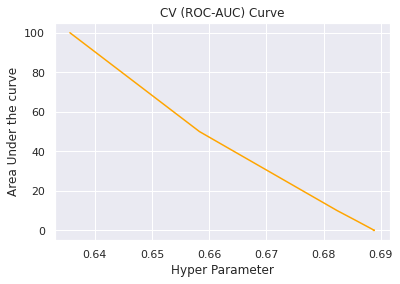

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

test_AUC = [value for index, value in enumerate(list(grid_result.cv_results_['mean_test_score'])) if index%2 != 0]
alphas = [values for index, values in enumerate(list(grid_result.cv_results_['param_alpha'])) if index % 2 == 0]

print(alphas)
sns.set(style="ticks")
sns.set(style='darkgrid')

sns.lineplot(test_AUC, alphas, color='orange')

plt.xlabel('Hyper Parameter')
plt.ylabel('Area Under the curve')
plt.title('CV (ROC-AUC) Curve')

plt.show();

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

%ls '/content/drive/My Drive/6_Donors_choose_NB/'

1_Reference_EDA.ipynb             6_Assignment_NB_Instructions.ipynb
2_Reference_Preprocessing.ipynb   glove_vectors
3_Reference_Vectorization.ipynb   preprocessed_data.csv
4_Reference_Vectorization.ipynb   resources.csv
5_Reference_SampleSolution.ipynb  train_data.csv


In [7]:
import gc
gc.collect()

path = '/content/drive/My Drive/6_Donors_choose_NB/'

X = pd.read_csv(path + 'preprocessed_data.csv', nrows=50000)
y = X['project_is_approved']
X = X.drop(['project_is_approved'], axis=1)

print(X.shape, y.shape)

(50000, 8) (50000,)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=0)

del X
del y

import gc

gc.collect()

0

In [9]:
from sklearn.preprocessing import Normalizer

ohe1 = CountVectorizer()
ohe1.fit(X_train['school_state'].values)
school_state_ohe_train = ohe1.transform(X_train['school_state'].values).toarray() # fit has to happen only on train data
school_state_ohe_test = ohe1.transform(X_test['school_state'].values).toarray()

ohe2 = CountVectorizer()
ohe2.fit(X_train['teacher_prefix'].values)
teacher_prefix_ohe_train = ohe2.transform(X_train['teacher_prefix'].values).toarray() # fit has to happen only on train data
teacher_prefix_ohe_test = ohe2.transform(X_test['teacher_prefix'].values).toarray()

ohe3 = CountVectorizer()
ohe3.fit(X_train['project_grade_category'].values)
project_grade_category_ohe_train = ohe3.transform(X_train['project_grade_category'].values).toarray() # fit has to happen only on train data
project_grade_category_ohe_test = ohe3.transform(X_test['project_grade_category'].values).toarray()

ohe4 = CountVectorizer()
ohe4.fit(X_train['clean_categories'].values)
clean_categories_ohe_train = ohe4.transform(X_train['clean_categories'].values).toarray() # fit has to happen only on train data
clean_categories_ohe_test = ohe4.transform(X_test['clean_categories'].values).toarray()

ohe5 = CountVectorizer()
ohe5.fit(X_train['clean_subcategories'].values)
clean_subcategories_ohe_train = ohe5.transform(X_train['clean_subcategories'].values).toarray() # fit has to happen only on train data
clean_subcategories_ohe_test = ohe5.transform(X_test['clean_subcategories'].values).toarray()

norm = Normalizer()
norm.fit(X_train['price'].values.reshape(-1,1))
X_train_price_norm = norm.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = norm.transform(X_test['price'].values.reshape(-1,1))

norm.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_no_prev_proj = norm.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_no_prev_proj = norm.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [10]:
X_train_essay = X_train['essay']
X_test_essay = X_test['essay']

X_train = np.column_stack((X_train_no_prev_proj, X_train_price_norm, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train, clean_subcategories_ohe_train))

X_test = np.column_stack((X_test_no_prev_proj, X_test_price_norm, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test, clean_subcategories_ohe_test))

gc.collect()

print("Final Data matrix")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

print("="*100)

Final Data matrix
(33500, 101) (33500,)
(16500, 101) (16500,)


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

def text_features(x, train, test):
    if x == 'tfidf':
      vectorizer = TfidfVectorizer(max_features = 5000, min_df = 10, ngram_range = (1, 2))
    elif x == 'bow':
      vectorizer = CountVectorizer(max_features = 5000, min_df = 10, ngram_range = (1, 2))
    
    vectorizer.fit(train)
    train = vectorizer.transform(train).toarray()
    test = vectorizer.transform(test).toarray()
    return train, test

model_features = dict()
count = 1

for features in ['tfidf', 'bow']:
  
  train_text, test_text = text_features(features, X_train_essay, X_test_essay)
  train_data = np.column_stack((X_train, train_text))
  test_data = np.column_stack((X_test, test_text))

  print(train_data.shape, Y_train.shape)
  print(test_data.shape, Y_test.shape)

  if features == 'tfidf' :
    model = MultinomialNB(alpha = 1e-05, class_prior = [0.5, 0.5])
  elif features == 'bow':
    model = MultinomialNB(alpha = 0.01, class_prior = [0.5, 0.5])

  out = model.fit(train_data, Y_train)
  model_features['model_'+str(count)] = out

  probs = model.predict_proba(train_data)  
  probs = probs[:, 1]
  train_fpr, train_tpr, test_thresholds = metrics.roc_curve(Y_train, probs)

  probs = model.predict_proba(test_data)  
  probs = probs[:, 1]
  test_fpr, test_tpr, train_thresholds = metrics.roc_curve(Y_test, probs)
  count+=1

  print("#"*50, "\n\n")

  print("\n", str(features) + "_AUC" + " : ", "\n")
  
  print("Train : ", metrics.auc(train_fpr, train_tpr),"\n")
  print("Test : ", metrics.auc(test_fpr, test_tpr),"\n")
  print("#"*50, "\n\n")

(33500, 5101) (33500,)
(16500, 5101) (16500,)
################################################## 



 tfidf_AUC :  

Train :  0.7218029269410847 

Test :  0.6802456520986246 

################################################## 


(33500, 5101) (33500,)
(16500, 5101) (16500,)
################################################## 



 bow_AUC :  

Train :  0.7398342037152453 

Test :  0.6967367810567857 

################################################## 




### BEST PARAMETERS FOR BOTH TEXT_FEATURES AND MODEL:

###```NOTE : ```

```
bow_AUC :  

Train :  0.7398342037152453 

Test :  0.6967367810567857 
```

## FINAL MODEL:

In [7]:
import gc
gc.collect()

path = '/content/drive/My Drive/6_Donors_choose_NB/'

X = pd.read_csv(path + 'preprocessed_data.csv')
y = X['project_is_approved']
X = X.drop(['project_is_approved'], axis=1)

print(X.shape, y.shape)

(109248, 8) (109248,)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=0)

In [9]:
from sklearn.preprocessing import Normalizer

ohe1 = CountVectorizer()
ohe1.fit(X_train['school_state'].values)
school_state_ohe_train = ohe1.transform(X_train['school_state'].values).toarray() # fit has to happen only on train data
school_state_ohe_test = ohe1.transform(X_test['school_state'].values).toarray()

ohe2 = CountVectorizer()
ohe2.fit(X_train['teacher_prefix'].values)
teacher_prefix_ohe_train = ohe2.transform(X_train['teacher_prefix'].values).toarray() # fit has to happen only on train data
teacher_prefix_ohe_test = ohe2.transform(X_test['teacher_prefix'].values).toarray()

ohe3 = CountVectorizer()
ohe3.fit(X_train['project_grade_category'].values)
project_grade_category_ohe_train = ohe3.transform(X_train['project_grade_category'].values).toarray() # fit has to happen only on train data
project_grade_category_ohe_test = ohe3.transform(X_test['project_grade_category'].values).toarray()

ohe4 = CountVectorizer()
ohe4.fit(X_train['clean_categories'].values)
clean_categories_ohe_train = ohe4.transform(X_train['clean_categories'].values).toarray() # fit has to happen only on train data
clean_categories_ohe_test = ohe4.transform(X_test['clean_categories'].values).toarray()

ohe5 = CountVectorizer()
ohe5.fit(X_train['clean_subcategories'].values)
clean_subcategories_ohe_train = ohe5.transform(X_train['clean_subcategories'].values).toarray() # fit has to happen only on train data
clean_subcategories_ohe_test = ohe5.transform(X_test['clean_subcategories'].values).toarray()

norm = Normalizer()
norm.fit(X_train['price'].values.reshape(-1,1))
X_train_price_norm = norm.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = norm.transform(X_test['price'].values.reshape(-1,1))

norm.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_no_prev_proj = norm.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_no_prev_proj = norm.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [10]:
X_train_essay = X_train['essay']
X_test_essay = X_test['essay']

X_train = np.column_stack((X_train_no_prev_proj, X_train_price_norm, school_state_ohe_train, teacher_prefix_ohe_train, project_grade_category_ohe_train, clean_categories_ohe_train, clean_subcategories_ohe_train))

X_test = np.column_stack((X_test_no_prev_proj, X_test_price_norm, school_state_ohe_test, teacher_prefix_ohe_test, project_grade_category_ohe_test, clean_categories_ohe_test, clean_subcategories_ohe_test))

gc.collect()

print("Final Data matrix")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

print("="*100)

Final Data matrix
(73196, 101) (73196,)
(36052, 101) (36052,)


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def text_features(x, train, test):
  if x == 'tfidf':
    vectorizer = TfidfVectorizer(max_features = 5000, min_df = 10, ngram_range = (1, 2))
  elif x == 'bow':
    vectorizer = CountVectorizer(max_features = 5000, min_df = 10, ngram_range = (1, 2))

  vectorizer.fit(train)
  train = vectorizer.transform(train).toarray()
  test = vectorizer.transform(test).toarray()
  return train, test

model = MultinomialNB(alpha = 0.01, class_prior = [0.5, 0.5])

train_text, test_text = text_features('bow', X_train_essay, X_test_essay)
train_data = np.column_stack((X_train, train_text))
test_data = np.column_stack((X_test, test_text))


In [ ]:
model = model.fit(train_data, Y_train)

Y_pred = model.predict(test_data)

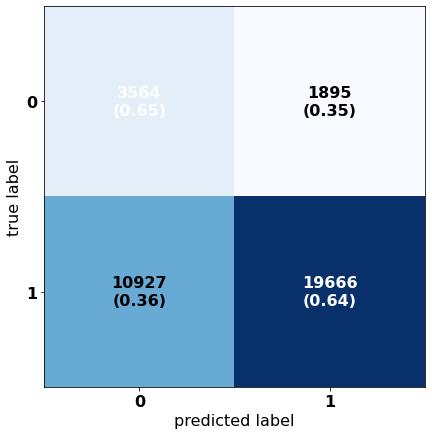

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

font = {
    'family' : 'DejaVu Sans',
    'weight' : 'bold',
    'size' : '16'
}

plt.rc('font', **font)

mat = confusion_matrix(Y_test, Y_pred)

plot_confusion_matrix(conf_mat=mat, figsize=(7,7), show_normed=True);

In [ ]:
Y_train_pred = model.predict(train_data)

print("train_roc_auc_score : " , roc_auc_score(Y_train, Y_train_pred))
print("test_roc_auc_score : ", roc_auc_score(Y_test, Y_pred))

probs = model.predict_proba(train_data)  
probs = probs[:, 1]
train_fpr, train_tpr, train_thresholds = metrics.roc_curve(Y_train, probs)

probs = model.predict_proba(test_data)  
probs = probs[:, 1]
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(Y_test, probs)

print("train_auc_score : " , metrics.auc(train_fpr, train_tpr))
print("test_auc_score : ", metrics.auc(test_fpr, test_tpr))

train_roc_auc_score :  0.665188483106524
test_roc_auc_score :  0.6478468079340801
train_auc_score :  0.7184353749037518
test_auc_score :  0.694146222581427


train_auc_score :  0.7184353749037518 


test_auc_score :  0.694146222581427 




No handles with labels found to put in legend.


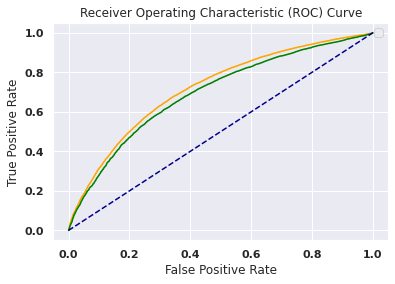

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
sns.set(style='darkgrid')
print("train_auc_score : " , metrics.auc(train_fpr, train_tpr), "\n\n")
print("test_auc_score : ", metrics.auc(test_fpr, test_tpr), "\n\n")

a = sns.lineplot(train_fpr, train_tpr, color='orange', label='_train_ROC')
b = sns.lineplot(test_fpr, test_tpr, color='green', label='_test_ROC')
sns.lineplot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.legend()
plt.show();

In [ ]:
print(list(np.argsort(model.feature_log_prob_[0])[::-1])[:20])

print(list(np.argsort(model.feature_log_prob_[1])[::-1])[:20])

[4144, 3713, 2449, 2910, 812, 3028, 2394, 4567, 2001, 4514, 2925, 1, 2929, 2725, 4886, 2944, 4988, 0, 905, 2629]
[4144, 3713, 2910, 2449, 812, 4514, 4567, 3028, 2925, 2394, 2001, 1, 2725, 2929, 4886, 4988, 2944, 3532, 4766, 0]


In [ ]:
print(X_train_no_prev_proj.shape, X_train_price_norm.shape, school_state_ohe_train.shape, teacher_prefix_ohe_train.shape, project_grade_category_ohe_train.shape, clean_categories_ohe_train.shape, clean_subcategories_ohe_train.shape, train_text.shape)

val = [X_test_no_prev_proj.shape[1], X_test_price_norm.shape[1], school_state_ohe_test.shape[1], teacher_prefix_ohe_test.shape[1], project_grade_category_ohe_test.shape[1], clean_categories_ohe_test.shape[1], clean_subcategories_ohe_test.shape[1], test_text.shape[1]]

train = {'X_train_no_prev_proj' : '[0,0]', 'X_train_price_norm' : '[0,1]', 'school_state_ohe_train' : '[2,53]', 'teacher_prefix_ohe_train' : '[54,58]', 'project_grade_category_ohe_train' : '[59,62]', 'clean_categories_ohe_train' : '[63, 71]', 'clean_subcategories_ohe_train' : '[72,101]', 'X_train_essay' : '[102:5101]'}


(73196, 1) (73196, 1) (73196, 51) (73196, 5) (73196, 4) (73196, 9) (73196, 30) (73196, 5000)


In [ ]:
print('columns : ', list(train.keys())) 

print('ranges : ', list(train.values()))

columns :  ['X_train_no_prev_proj', 'X_train_price_norm', 'school_state_ohe_train', 'teacher_prefix_ohe_train', 'project_grade_category_ohe_train', 'clean_categories_ohe_train', 'clean_subcategories_ohe_train', 'X_train_essay']
ranges :  ['[0,0]', '[0,1]', '[2,53]', '[54,58]', '[59,62]', '[63, 71]', '[72,101]', '[102:5101]']


```
### TOP 20 NEGATIVE CLASS PROB Features

1 : 'X_test_price_norm',
0 : 'X_train_no_prev_proj',
4144 : 'X_train_essay' #remaining 18 features from essay
```


```
### TOP 20 POSITIVE CLASS PROB Features

1 : 'X_test_price_norm',
0 : 'X_train_no_prev_proj',
4144 : 'X_train_essay' #remaining 18 features from essay
```



## Summary

In [ ]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper_Parameter", "Train_AUC", "Test_AUC"]

x.add_row(["BOW", 'MNB', 'Alpha : 0.01', 0.73, 0.69])
x.add_row(["TFIDF", 'MNB', 'Alpha : 1e-5', 0.72, 0.69])

print(x)

+------------+-------+-----------------+-----------+----------+
| Vectorizer | Model | Hyper_Parameter | Train_AUC | Test_AUC |
+------------+-------+-----------------+-----------+----------+
|    BOW     |  MNB  |   Alpha : 0.01  |    0.73   |   0.69   |
|   TFIDF    |  MNB  |   Alpha : 1e-5  |    0.72   |   0.69   |
+------------+-------+-----------------+-----------+----------+
